## Packages Installation

In [ ]:
!pip install qiskit[all]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.9/806.9 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 

## Motivation

This notebook demonstrates the practical considerations for perfoming dynamical evolution of an Hamiltonian written in the basis of Pauli matrices using a qubit-based quantum computer framework. The chosen Hamiltonian can be used to describe the chemical process of electron transfer across a chromophore chain, with the onsite parameters describing the strength of the electronic affinity at each chromophore and off-site couplings describing the barrier for transferring an electron between adjacent sites.

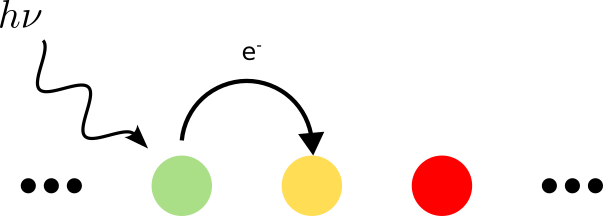

A problem of practical interest that could be modelled by this method would be a functionalized graphene nanoribbon, where alternating sites contain radical character ([Nano Lett. 2022, 22, 1, 164–171](https://pubs.acs.org/doi/10.1021/acs.nanolett.1c03578)).

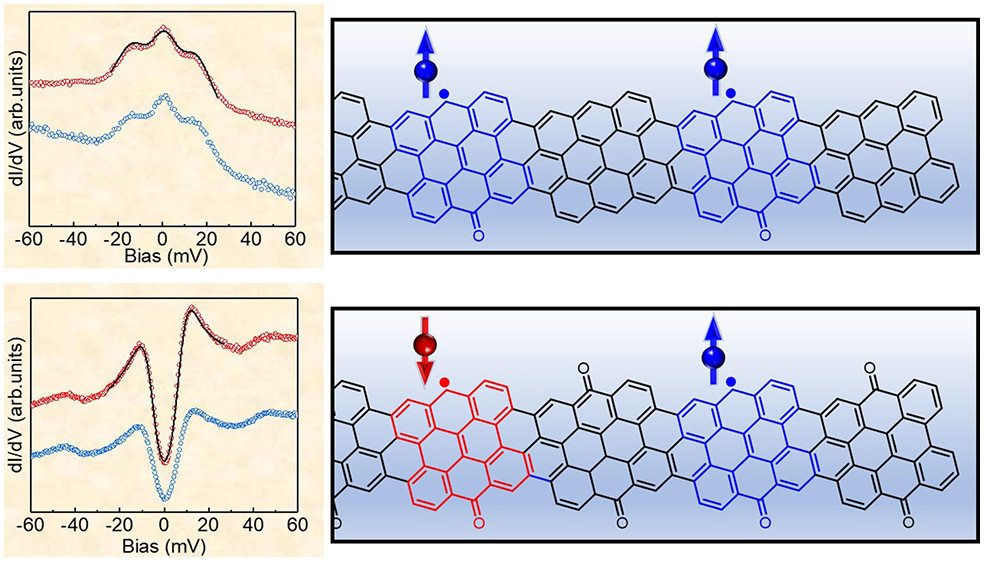

The stability of the radical character at each site can be described by the on-site parameter ($\Omega _n$) and the coupling between sites ($J _{n,n+1}$) governed by the properties of the linker regions containing the diketone groups. These parameters can be tuned by synthetic design of each component part of the nanoribbon.

\begin{equation}
H=  \sum_{n=0}^{N-1} \hbar \Omega _n \sigma_n ^z - \dfrac{1}{2} \sum_{n=0}^{N-2} \big(J_{n,n+1}^x \hat{\sigma}_{n}^x \hat{\sigma}_{n+1}^x + J_{n,n+1}^y \hat{\sigma}_{n}^y \hat{\sigma}_{n+1}^y + J_{n,n+1}^z \hat{\sigma}_{n}^z \hat{\sigma}_{n+1}^z \big)
\end{equation}

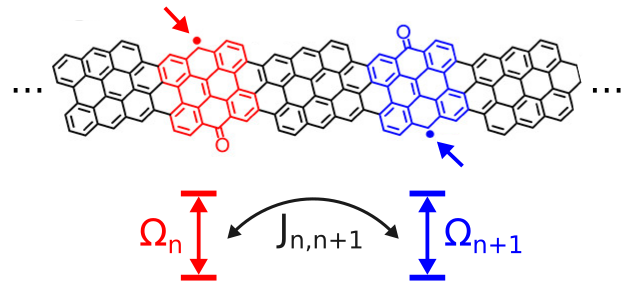

## Outline

Protocol for Hamiltonian evolution in a quantum computer framework:

1.   Construct Hamiltonian operator (sum of tensor product of Pauli matrices)
2.   Construct Trotter approximation of time-evolution operator ($e^{-i\hat{H}t}$)
3.   Construct circuit corresponding to time-evolution operator
4.   Construct circuit for initial state
5.   Combine the initial state and time-evolution circuits
6.   Execute combined circuit
7.   Measure final state
8.   Computing observables with Hadamard test (correlation function and observables)

## Model Hamiltonian and Parameters

Here we use as an example the Hamiltonian for the Heisenberg model, defined as follows:
\begin{equation}
H=  \sum_{n=0}^{N-1} \hbar \Omega _n \sigma_n ^z - \dfrac{1}{2} \sum_{n=0}^{N-2} \big(J_{n,n+1}^x \hat{\sigma}_{n}^x \hat{\sigma}_{n+1}^x + J_{n,n+1}^y \hat{\sigma}_{n}^y \hat{\sigma}_{n+1}^y + J_{n,n+1}^z \hat{\sigma}_{n}^z \hat{\sigma}_{n+1}^z \big)
\end{equation}
where the coupling elements are described in terms of the $\sigma _x, \sigma _y, \sigma _z$ (Pauli X, Y and Z) matrices with a coupling associated with each type of interaction term for each site/pair of sites. We consider the following parameters, as used in the publication [Non-Markovian decay beyond the Fermi Golden Rule: Survival Collapse of the polarization in spin chains.](https://arxiv.org/pdf/quant-ph/0511176v2.pdf)(but with reduced number of spin sites):
\begin{align}
    N &= 3 \\
    \hbar \Omega _0 &= 0.65 \\
    \hbar \Omega _n &= 1.0, \; n > 0 \\
    J_{0,1}^x = J_{1,0}^y &= 0.75 \\
    J_{n,n+1}^x = J_{n,n+1}^y &= 1.0, \; n > 0  \\
    J_{n,n+1}^z &= 0, \; \forall n \\
\end{align}
for a chain of $N=3$ spins and an initial state with the first spin up, $| \uparrow \rangle = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$, and the remaining spins down, $| \downarrow \rangle = \begin{bmatrix} 0 \\ 1\end{bmatrix}$.
Although the dynamics of this Hamiltonian can be simulated in a classical computer, we could also use quantum computer to simulate this same problem. One way to do so is by harnessing Qiskit, a python library containing functions that ease the simulation of the problem in quantum device framework.

### Functions

In [ ]:
from qiskit.quantum_info import Pauli, Operator, SparsePauliOp # includes representations of operators and Pauli matrix operators
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter # Trotter-Suzuki implementation for decomposition of exponentials of matrices
from qiskit import QuantumCircuit, transpile, execute, QuantumRegister, ClassicalRegister
# from qiskit_aer import AerSimulator
from qiskit import BasicAer
import numpy as np
import matplotlib.pyplot as plt


def OPauli(s): # move this to more relevant section
    # creates Pauli operation (from string chain)
    # ie, converts IIIIXXIIII to actual tensor product of Pauli matrices
    return SparsePauliOp(Pauli(s))


def get_controlled_operation_from_dict(num_qubits, circ_instructions,
                                       cbits_indices, circ_dict=True):
    '''
        Generates a controlled operation given a specific number of qubits
        and a dictionary containing a set of circuit instructions. The set
        of controlled qubits indices must also be provided. Returns the resulting
        operation.
    '''
    if circ_dict:
        qc = get_quantum_circuit_from_dict(circ_instructions, num_qubits)
        # qc = transpile(qc, backend, optimization_level=2)
        custom_control = qc.to_gate().control(len(cbits_indices))
    else:
        custom_control = circ_instructions.to_gate().control(len(cbits_indices))
    return custom_control


def get_init_state(n_qubits, init_state_indices):
    '''
        Generates an initial state representation to prepare the simulation
        of the circuit of choice.
    '''
    assert n_qubits == len(init_state_indices), f"Expected number qubits ({n_qubits}) equal to init_state_indices ({len(init_state_indices)})"

    # initializes the quantum circuit with the specified number of qubits
    qc = QuantumCircuit(n_qubits)
    for idx, state in enumerate(init_state_indices):
        if state == 2:
            qc.h(idx)
        elif state == 1:
            qc.x(idx)
        else:
            qc.i(idx)
    return qc


def get_quantum_circuit_from_dict(circuit_dict, n_qubits):
    '''
        This function takes a dictionary containing gate type, circuit wires it
        affects and the parameters associated with the gate (if any) as well as
        the number of qubits associated with the circuit to generate a qiskit
        quantum circuit object.
    '''
    # initializes the quantum circuit with the specified number of qubits
    qc = QuantumCircuit(n_qubits)
    # translates the dictionary information into the appropriate gates
    # note that only the gates listed below are supported; if more are needed
    # include additional elif statements.
    for v in circuit_dict.values():
        if v[0] == 'h':
            qc.h(v[1][0])
        elif v[0] == 'cx':
            qc.cx(v[1][0], v[1][1])
        elif v[0] == 'rx':
            qc.rx(v[2][0], v[1][0])
        elif v[0] == 'ry':
            qc.ry(v[2][0], v[1][0])
        elif v[0] == 'rz':
            qc.rz(v[2][0], v[1][0])
        elif v[0] == 'sx':
            qc.sx(v[1][0])
    return qc


# def get_hadamard_test_circ(num_qubits, circ_instructions, cbits_indices=None,
#                            state=None, circ_dict=True, imag=False):

#     # number of qubits in quantum register, +1 ancilla qubit
#     qr = QuantumRegister(num_qubits+1, 'q')
#     # classical register to record measurement of the ancilla qubit.
#     cr = ClassicalRegister(1, 'c')
#     # Assembling the quantum circuit from the registers
#     qc = QuantumCircuit(qr, cr) # instantiated here
#     # qc.append(get_init_state)
#     # Including the Hadamard gate on the ancilla qubit
#     qc.h(0)
#     if imag:
#         qc.p(-np.pi/2, 0)
#     # different initial state
#     if state != None:
#         init_state = get_init_state(num_qubits + 1, [0] + state)
#         qc.append(init_state, [0] + list(range(1,num_qubits+1)))

#     # Generating and including the controlled unitary
#     if circ_dict:
#         custom_control = get_controlled_operation_from_dict(
#             num_qubits, circ_instructions, cbits_indices)
#     else:
#         # print('Hello')
#         custom_control = circ_instructions
#     qc.append(custom_control, [0] + list(range(1,num_qubits+1)))
#     # Including the Hadamard gate on the ancilla qubit
#     qc.h(0)
#     qc.measure(0,0)
#     return qc


def get_spin_correlation(counts):
    '''
        Generates the spin correlation at a particular time by averaging over
        the counts of the ancillary qubit.
    '''

    qubit_to_spin_map = {
        '0': 1,
        '1': -1,
    }
    total_counts = 0
    values_list = []
    for k,v in counts.items():
        values_list.append(qubit_to_spin_map[k] * v)
        total_counts += v
    # print(values_list)
    average_spin = (sum(values_list)) / total_counts
    return average_spin

## Hamiltonian Preparation

The state of each spin will be mapped to the state of a qubit. Each term in the Hamiltonian is a Kronecker product of Pauli matrices, that needs to be transformed into an operator, corresponding to the Kronecker product of spin operators. For example, we represent the term associated with $\hat{\sigma}_{n}^y \hat{\sigma}_{n+1}^y$ as the following tensor product of operators, generated with the qiskit `SparsePauliOp(Pauli(s))` (note that `SparsePauliOp(s)` also works) from strings of characters `s='I...YY...I'`, where the Y Pauli operators have indices $n, n+1$ of the overall string:
\begin{equation}
     \hat{\sigma}_{n}^y \hat{\sigma}_{n+1}^y = I \otimes I \cdots \otimes Y_{n} \otimes Y_{n+1} \otimes \cdots \otimes I
\end{equation}

We can write a function to produce a list of the terms of the Hamiltonian for a specific spin as follows:

In [ ]:
def get_hamiltonian_n_site_terms(n, coeff, n_qubits):
    '''
        Defines the Heisenberg model interaction for a given number of qubits
        (spins) with the interaction occurring on site i (0 indexed). The
        coeff_list indicates the coefficients associated with each interaction
        term.

        Input:
            i (integer): specifies index of the n spin the chain
            coeff (list of lists): specifies the list of coefficients containing
                the ordered
                coefficients per site/pair of sites. Each element in the list
                contains [XX, YY, ZZ, Z] coefficients
            n_qubits (integer): specifies the number of spins in the chain

        Returns:
            SparsePauliOp object: contains the individual products of Pauli terms
                with associated coefficients
    '''
    assert n < n_qubits - 1, f"Two site interactions must be less than {n_qubits-1}"
    # i qubits before target qubits and n_qubits -2 -i after target qubits
    # ie IIIIXXIIII + IIIIYYIIII + IIIIZZIIII + IIIIZIIIII
    XX_coeff = coeff[0]
    YY_coeff = coeff[1]
    ZZ_coeff = coeff[2]
    Z_coeff = coeff[3]
    return (SparsePauliOp(("I" * n + "XX" + "I" * (n_qubits - 2 - n))) * XX_coeff +
            SparsePauliOp(("I" * n + "YY" + "I" * (n_qubits - 2 - n))) * YY_coeff +
            SparsePauliOp(("I" * n + "ZZ" + "I" * (n_qubits - 2 - n))) * ZZ_coeff +
            SparsePauliOp(("I" * n + "Z" + "I" * (n_qubits - 1 - n))) * Z_coeff)

For all the spins in the system, we can write the following function that generates the complete Hamiltonian. This function in conjunction with the one above can be adapted to prepare a different Hamiltonian.

In [ ]:
# functions to create the circuit for the Heisenberg model
def get_heisenberg_hamiltonian(n_qubits, coeff=None):
    """
        Construct Hamiltonian of 1-D Heisenberg chain with n_qubits sites.
        Return a list of matrices corresponding to the even-odd-splitting (154)
        in Childs et al (2021) Phys Rev X 11, 011020.
        Modified from the original function to support explicit coefficients
        for each of the components of the interaction.

        Returns:
        H_E (SparsePauliOp): contains the sum of even operator terms per spin of
            the Heisenberg Hamiltonian with associated coefficients per term
        H_O (SparsePauliOp): the sum of odd operator terms per spin of the
            Heisenberg Hamiltonian with associated coefficients per term
        H_E, H_O] (list of SparsePauliOp): a list containing the even and odd terms
    """
    # Three qubits because for 2 we get H_O = 0
    assert n_qubits >= 3
    if coeff == None:
        coeff = [[1.0, 1.0, 1.0, 1.0] for i in range(n_qubits)]
    # Even terms of the Hamiltonian (summing over individual pair-wise elements)
    H_E = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(0, n_qubits-1, 2)))

    # Odd terms of the Hamiltonian (summing over individual pair-wise elements)
    H_O = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(1, n_qubits-1, 2)))
    # adding final Z term
    if (n_qubits % 2) == 0:
        H_E += SparsePauliOp(("I" * (n_qubits - 1)  + "Z")) * coeff[n_qubits-1][3]
    else: # SparsePauliOp(("I" * i + "Z" + "I" * (n_qubits - 1 - i))) * coeff[3]
        H_O += SparsePauliOp(("I" * (n_qubits - 1)  + "Z")) * coeff[n_qubits-1][3]
    # Returns the list of the two sets of terms
    return [H_E, H_O]

## Time Evolution Operator

The function below prepares the trotterized time-evolution operator for Hamiltonian.

In [ ]:
def get_time_evolution_operator(num_qubits, tau, trotter_steps, coeff=None):
    '''
        Given a number of qubits, generates the corresponding time-evolution for
        the Ising model with the same number of sites.

        Input:
            num_qubits (int): number of qubits, which should be equal to the
                number of spins in the chain
            evo_time (float): time parameter in time-evolution operator
            trotter_steps (int): number of time steps for the Suzuki-Trotter
                decomposition
            coeff (list of lists): parameters for each term in the Hamiltonian
                for each site ie ([[XX0, YY0, ZZ0, Z0], [XX1, YY1, ZZ1, Z1], ...])
        Returns:
            evo_op.definition: Trotterized time-evolution operator
    '''
    # Constructing the Hamiltonian here; heisenberg_hamiltonian = [H_E, H_O]
    heisenberg_hamiltonian = get_heisenberg_hamiltonian(num_qubits, coeff)

    # e^ (-i*H*evo_time), with Trotter decomposition
    # exp[(i * evo_time)*(IIIIXXIIII + IIIIYYIIII + IIIIZZIIII + IIIIZIIIII)]
    evo_op = PauliEvolutionGate(heisenberg_hamiltonian, tau,
                                synthesis=SuzukiTrotter(order=2, reps=trotter_steps))
    # The Trotter order=2 applies one set of the operators for half a timestep,
    # then the other set for a full timestep, then the first step for another half a step
    # note that reps includes the number of repetitions of the Trotterized operator
    # higher number means more repetitions, and thus allowing larger timestep
    return evo_op.definition

With the Hamiltonian defined as above, we can generate the time-evolution operator for a given set of parameters:

In [ ]:
num_shots = 100
num_q = 3
evolution_timestep = 0.1
n_trotter_steps = 1
# XX YY ZZ, Z
hamiltonian_coefficients = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                            + [[0.5, 0.5, 0.0, 1.0] for i in range(num_q-1)])

Generating the operator representation and visualizing it:

In [ ]:
time_evo_op = get_time_evolution_operator(
    num_qubits=num_q, tau=evolution_timestep,
    trotter_steps=n_trotter_steps, coeff=hamiltonian_coefficients)

print(time_evo_op)

     ┌───────────────────────────────────────┐»
q_0: ┤0                                      ├»
     │                                       │»
q_1: ┤1 exp(it ['XXI', 'YYI', 'III', 'ZII']) ├»
     │                                       │»
q_2: ┤2                                      ├»
     └───────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────┐»
«q_0: ┤0                                             ├»
«     │                                              │»
«q_1: ┤1 exp(it ['IXX', 'IYY', 'III', 'IZI', 'IIZ']) ├»
«     │                                              │»
«q_2: ┤2                                             ├»
«     └──────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────┐
«q_0: ┤0                                      ├
«     │                                       │
«q_1: ┤1 exp(it ['XXI', 'YYI', 'III', 'ZII']) ├
«     │                                       │
«q_2: ┤2                        

## Circuit Preparation

Setting up the circuit framework with the appropriate number of qubits (each representing a spin)

In [ ]:
# used to compile the circuit, tranpiling to the set of operations supported by the device backend and execution
from qiskit import QuantumCircuit, transpile, execute, QuantumRegister, ClassicalRegister
# from qiskit_aer import AerSimulator

qr = QuantumRegister(num_q)
cr = ClassicalRegister(num_q)
qc = QuantumCircuit(qr, cr) # instantiated here

If measured, this would yield the vacuum state.

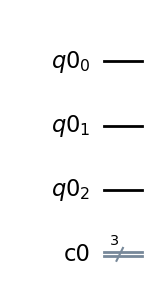

In [ ]:
qc.draw('mpl')

Here we define the initial state for the model system, by amplitude encoding on the vacuum state.

In [ ]:
# qc.h(list(range(num_qubits))) # superposition on first site (via hadamard)
for qubit_idx in range(num_q):
    if qubit_idx == 0:
        qc.i(qubit_idx) # generate only one spin-up at first qubit
    else:
        qc.x(qubit_idx) # make all other spins have the spin-down state
qc.barrier()

Visualize it.

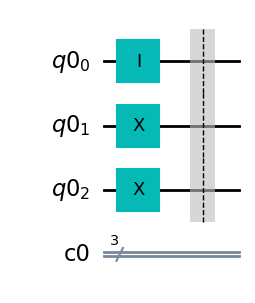

In [ ]:
qc.draw('mpl') # up, down, down

Checking the initial state in vector form.

In [ ]:
from qiskit import BasicAer

qc_init_state = execute(qc, backend=BasicAer.get_backend('statevector_simulator')).result()
qc_init_state = qc_init_state.get_statevector()
print(qc_init_state)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]


Append the time-evolution operator for the chosen Hamiltonian:

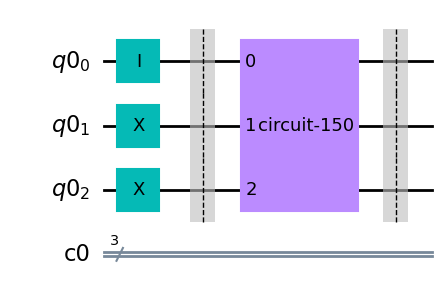

In [ ]:
# appending the Hamiltonian evolution to the circuit
qc.append(time_evo_op, list(range(num_q)))
qc.barrier()
qc.draw('mpl')

Include measurement operators to obtain the final state:

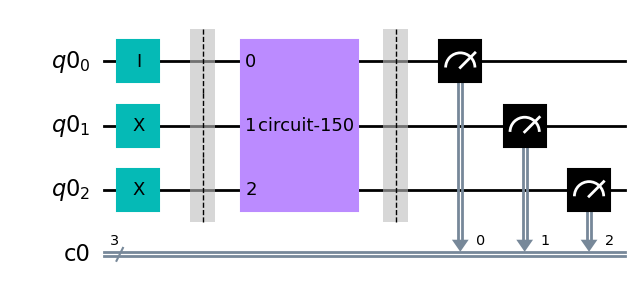

In [ ]:
qc.measure(range(num_q), range(num_q))
qc.draw('mpl')

Checking the depth of the circuit:

In [ ]:
print('Depth of the circuit is', qc.depth())

Depth of the circuit is 3


Performing transpilation to convert the operators in the circuit into suitable gate representations (the specific set of operations supported by the quantum device or simulator).

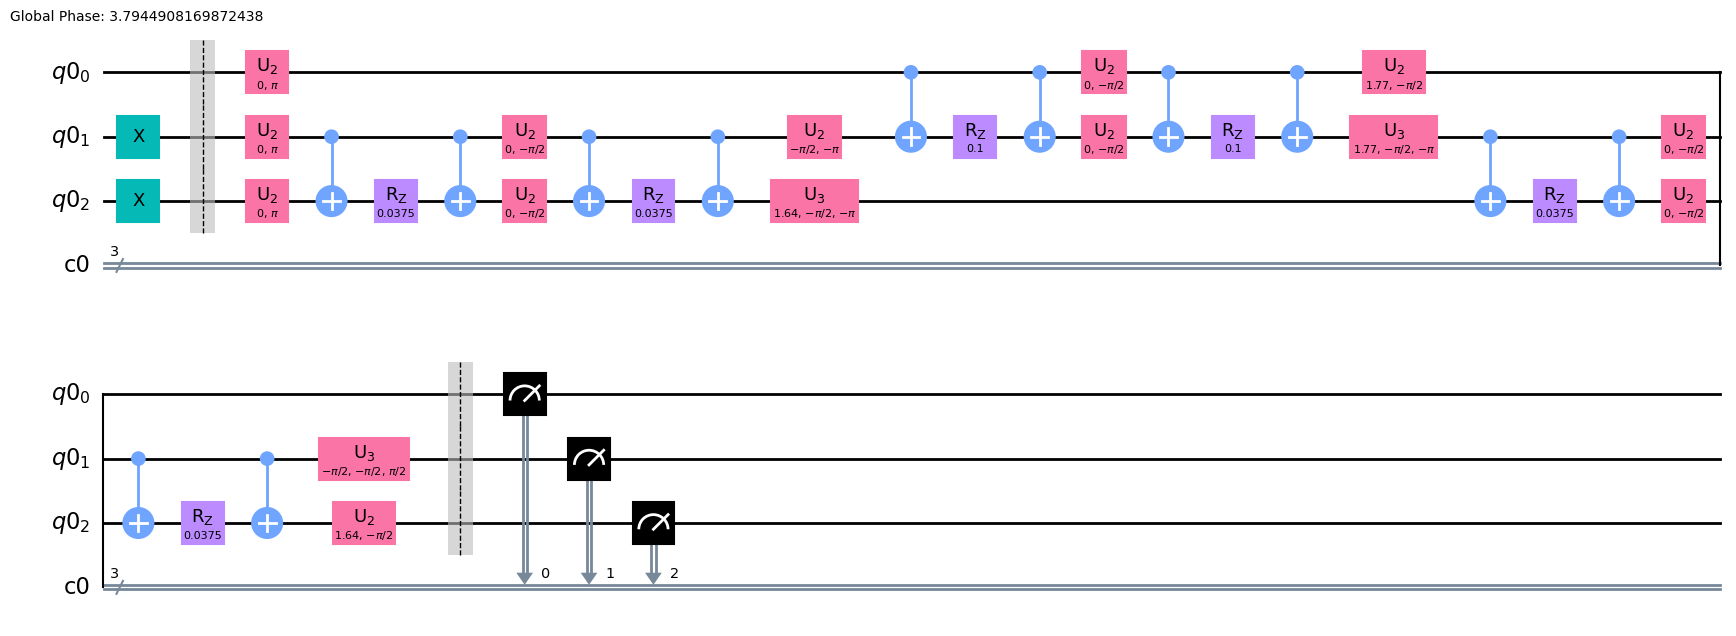

In [ ]:
# transpiled circuit to statevector simulator
backend = BasicAer.get_backend('statevector_simulator')
qct = transpile(qc, backend, optimization_level=2)
qct.draw('mpl')

Checking the depth after transpilation

In [ ]:
print('Depth of the circuit after transpilation is', qct.depth())

Depth of the circuit after transpilation is 27


Executing and obtaining the final statevector.

In [ ]:
qct_run = execute(qct, backend, shots=127).result()
qct_run_counts = qct_run.get_counts()

In [ ]:
print(qct_run.get_counts())

{'110': 1}


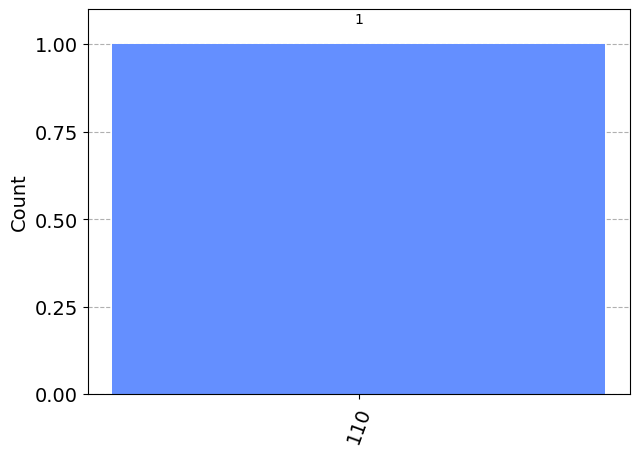

In [ ]:
# # For visualization
from qiskit.visualization import plot_histogram
plot_histogram(qct_run.get_counts(qct))

#### Statevector Simulation Section for Correlation

This executes the circuit by re-initialization. At each time in the iteration, it uses the final state for the prior time-step ($\psi _{\text{init}} = \psi _{n} = e^{i\hat{H} \tau/\hbar}\psi _{n-1}$)

In [ ]:
# Quantum circuit for propagation
def qsolve_statevector(psin, qc):
    '''
        Performs dynamical propagation for a specific quantum circuit, using the
        an initial state equal to the result of the prior iteration. In effect,
        this propagates:

        | \psi _t \rangle  = e^{i*\tau*H/hbar} e^{i*\tau*H/hbar} ... | \psi _0 \rangle
        -> | \psi _t \rangle  = e^{i*\tau*H/hbar} | \psi _{t-\tau} \rangle

        Use of reinitialization in this way is possible due to the usage of the
        statevector_simulator backend; this may not be practical for an
        implementation on actual hardware.
        Returns:
            psin (statevector): final statevector after execution
    '''
    # Determining number of qubits from the length of the state vector
    n=np.size(psin)
    d=int(np.log2(np.size(psin)))
    # Circuit preparation
    qre = QuantumRegister(d)
    circ = QuantumCircuit(qre)
    circ.initialize(psin,qre)
    circ.barrier()
    # for i in range(0,100):
    circ.append(qc, qre)
    circ.barrier()
    # Circuit execution
    psin = execute(circ, backend=BasicAer.get_backend('statevector_simulator')).result()
    psin = psin.get_statevector()
    return psin

Initial state preparation based on array (one of the ways to accomplish this).

In [ ]:
# Qubit basis states
zero_state = np.array([[1],[0]])
one_state = np.array([[0],[1]])
# For a 011 initial state prepare as follows
psin = zero_state # for the first spin
# iterates over the remaining spins, by performing Kronecker Product
for i in range(num_q-1):
    psin = np.kron(psin, one_state)
psin0 = psin.flatten()
print(psin0)

[0 0 0 1 0 0 0 0]


The time-evolution operator being used in the subsequent cell is the same as the one defined above with the parameters described at the beginning.

In [ ]:
nsteps = 250 # number of steps for which to propagate (totaling 25 units of time)

psin_list = []
psin_list.append(psin0)
correlation_list = []
# performs dynamical propagation by statevector re-initialization
for k in range(nsteps):
    if k > 0:
        psin = qsolve_statevector(psin_list[-1], time_evo_op)
        # removes the last initial state to save memory
        psin_list.pop()
        # stores the new initial state
        psin_list.append(psin)
    correlation_list.append(np.vdot(psin_list[-1],psin0))

In [ ]:
# This is the depth of the time evolution operator; however, it considers
# each big block as only one gate, which is not accurate to the true depth
print(time_evo_op.depth())

3


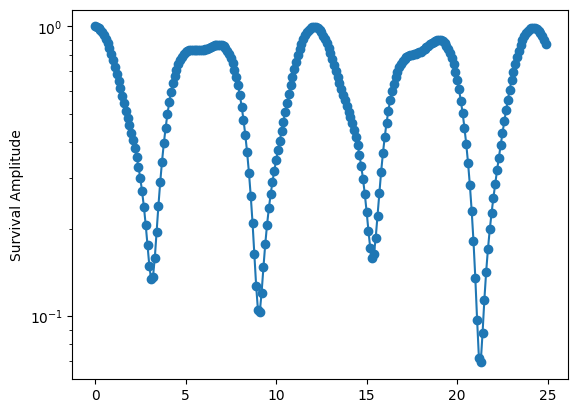

In [ ]:
import matplotlib.pyplot as plt

t= np.arange(0,evolution_timestep*(nsteps), evolution_timestep)
plt.plot(t, np.abs(correlation_list), '-o')
plt.ylabel('Survival Amplitude')
plt.yscale('log')
plt.show()

# Correlation Function with Hadamard Test

The calculation of correlation functions using a quantum device can be performed by the Hadamard test. The [Hadamard test](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)) allows evaluation of the expectation values of Unitary operators using quantum circuits. See also [Simulating physical phenomena by quantum networks](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.65.042323). It requires using a circuit containing an ancillary qubit to store the information pertaining to the correlation function. The circuit form is highlighted below, where the controlled unitary contains the operator of interest.

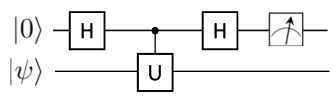

Conditional gates A and B can be applied to measure the correlation function,
\begin{equation}
    C_{AB} = \langle \Psi _0 | A ^{\dagger} B | \Psi_0 \rangle,
\end{equation}
by measuring the expectation value $\langle 2 \sigma ^+ \rangle = 2(\sigma _x + i\sigma _y)$ for an ***ancilla qubit***. In this case, the autocorrelation function implies $A=1$ and $B=e^{-iH\tau /\hbar}$ for a particular time $\tau$.

This can also be extended to multi-time correlation functions. The result of the real part of the correlation function are given by the following circuit architecture, which prepares the ancilla in the superposition state $| + \rangle = \dfrac{1}{2}\Big(|0 \rangle + | 1 \rangle \Big)$,

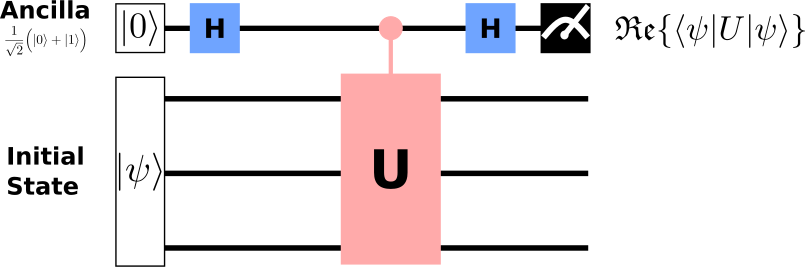

The imaginary part of the correlation function is given by the following circuit architecture, which contains an additional phase gate with angle $-\pi/2$, $P(\pi/2) = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi/2} \end{bmatrix}$, which prepares the ancilla in the superposition state $\dfrac{1}{2}\Big(|0 \rangle -i | 1 \rangle \Big)$,

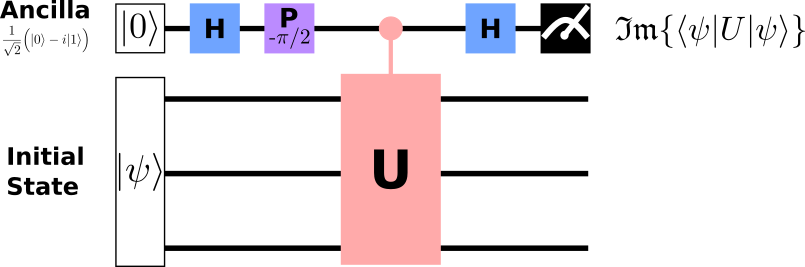

## Hadamard Test Function

In [ ]:
def get_hadamard_test(
    num_qubits, initial_state, control_operation,
    control_repeats=0, imag_expectation=False):
    '''
        Writes the Hadamard test circuit to evaluate the real (or imaginary)
        components of a given operator (or set of operators) by measuring the
        ancilla.

        Inputs:
            num_qubits (int): number of qubits needed for the calculation
            initial_state: quantum circuit object containing the initialization
                for the system
            control_operation: quantum circuit object containing the controlled
                version of the unitary operator for which to evaluate the
                expectation value
            control_repeats (int): number of repetitions of the controlled
                operation in the Hadamard test circuit (such as time-propagation)
            imag_expectation (boolean): whether to assemble the circuit for
                evaluation of the real or imaginary components of the operator.
        Returns:
            qc_hadamard: quantum circuit object containing the hadamard test
    '''
    # Circuit object framework
    qr_hadamard = QuantumRegister(num_q+1)
    cr_hadamard = ClassicalRegister(1)
    qc_hadamard = QuantumCircuit(qr_hadamard, cr_hadamard) # instantiated here
    # Initialization of calculation qubits
    qc_hadamard.append(initial_state, qr_hadamard[1:]) # initial psi
    qc_hadamard.barrier()
    # Hadamard test structure
    qc_hadamard.h(0)
    if imag_expectation:
        qc_hadamard.p(-np.pi/2, 0) # qc_hadamard.s(0).inverse() may be equivalent
    # iterates over the number of times the control operation should be added
    for i in range(control_repeats):
        qc_hadamard.append(control_operation, qr_hadamard[:])
    qc_hadamard.h(0)
    qc_hadamard.barrier()
    # Measuring the ancilla
    qc_hadamard.measure(0,0)
    return qc_hadamard


def get_circuit_execution_counts(qc, backend, n_shots=100):
    '''
        Takes a quantum circuit, Qiskit supported backend and a specified number
        of execution times to calculate the number of times each state in the
        circuit was measured.

        Inputs:
            qc: Qiskit quantum circuit object
            backend: qiskit supported quantum computer framework (either simulator
                or actual device)
                n_shots (int): default=100; number of times for which to execute
                    the circuit using the specified backend.
    '''
    qc_execution = execute(qc, backend, shots=n_shots)
    counts = qc_execution.result().get_counts()
    return counts # number of times measured 0 and 1


def get_initialization(num_qubits, initialization_string):
    '''
        Creates a circuit containing the qubit initialization for a specified
        number of qubits and given initialization string. There are alternative
        methods to initialize the circuit besides the one used in this function
        including using a statevector or amplitude embedding of an arbitrary state.
    '''
    qr_init = QuantumRegister(num_qubits)
    qc_init = QuantumCircuit(qr_init)
    qc_init.initialize(initialization_string, qr_init[:]) # 0x1x1
    return qc_init

## Backends

For the IBM Quantum Experience, use the code below ([this link for more information](https://qiskit.org/ecosystem/ibmq-provider/tutorials/1_the_ibmq_account.html))

In [ ]:
from qiskit import IBMQ


use_IBMQ = False
if use_IBMQ:
    IBMQ.save_account('TOKEN')
    IBMQ.load_account() # Load account from disk


In [ ]:
if use_IBMQ:
    print(IBMQ.providers())    # List all available providers
    provider = IBMQ.get_provider(hub='ibm-q')
    print(provider.backends())

In [ ]:
if use_IBMQ:
    actual_quantum_device = provider.backend.ibmq_belem

For simulators within the BasicAer module.

In [ ]:
# simulator=BasicAer.get_backend('qasm_simulator')
# Select the AerSimulator from the Aer provider
# simulator = AerSimulator(method='matrix_product_state')
simulator = BasicAer.get_backend('statevector_simulator')

## Parameterization of Hamiltonian

The Hamiltonian preparation is the same as defined earlier in the notebook, and
the time-evolution operator is therefore the same. The number of shots is increased to a 1000 for better agreement with the benchmark code (which can be
used to reproduce the results listed on the paper for 20 spins).

In [ ]:
num_shots = 100 # increase to check for convergence
evolution_timestep=0.1
total_time = 25
time_range = np.arange(0, total_time+evolution_timestep, evolution_timestep)

Creates the controlled version of the time-evolution operator to be used within the Hadamard test.

In [ ]:
controlled_time_evo_op = time_evo_op.control() # for closed control
# controlled_time_evo_op = time_evo_op.control(ctrl_state=0) # for open control

Encodes the initial state for the Heisenberg spin chain (one spin down at the first site, all others spin-up).

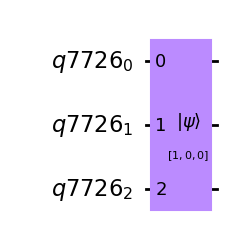

In [ ]:
init_state_list = '1' + '0' * (num_q-1)

init_circ = get_initialization(num_q, init_state_list)
init_circ.draw('mpl')

## Execution of Time Evolution with Hadamard Test

This execution takes >1 hour using the parameters defined above. It computes both the real and imaginary components of the autocorrelation function using the
Hadamard test function.

In [ ]:
# switch this variable to True to perform execution of the for loop.
# it takes >1hr for 3 spins, with the parameters defined above and 1000 shots
# for each time step.
run_hadamard_test_boolean = False
# run_hadamard_test_boolean = True
real_amp_list = []
imag_amp_list = []
if run_hadamard_test_boolean:
    for idx,time in enumerate(time_range):
        qc_had_real = get_hadamard_test(num_q, init_circ, controlled_time_evo_op,
                                        control_repeats=idx, imag_expectation=False)
        had_real_counts = get_circuit_execution_counts(qc_had_real, simulator,
                                                    n_shots=num_shots)
        real_amplitude = get_spin_correlation(had_real_counts)
        real_amp_list.append(real_amplitude)

        qc_had_imag = get_hadamard_test(num_q, init_circ, controlled_time_evo_op,
                                        control_repeats=idx, imag_expectation=True)
        had_imag_counts = get_circuit_execution_counts(qc_had_imag, simulator,
                                                    n_shots=num_shots)
        imag_amplitude = get_spin_correlation(had_imag_counts)
        imag_amp_list.append(imag_amplitude)

    real_amp_array = np.array(real_amp_list)
    imag_amp_array = np.array(imag_amp_list)

A more accurate estimation of the depth for the range of 0-5 repetitions of the time-evolution operator. Each time-evolution operator has about 250 depth (no symmetry or simplifications besides what Qiskit may do by default)

In [ ]:
print(qc)

      ┌───┐ ░ ┌──────────────┐ ░ ┌─┐      
q0_0: ┤ I ├─░─┤0             ├─░─┤M├──────
      ├───┤ ░ │              │ ░ └╥┘┌─┐   
q0_1: ┤ X ├─░─┤1 circuit-150 ├─░──╫─┤M├───
      ├───┤ ░ │              │ ░  ║ └╥┘┌─┐
q0_2: ┤ X ├─░─┤2             ├─░──╫──╫─┤M├
      └───┘ ░ └──────────────┘ ░  ║  ║ └╥┘
c0: 3/════════════════════════════╩══╩══╩═
                                  0  1  2 


In [ ]:
print(qc.decompose().decompose())

         ┌───┐     ░                                 ┌───────────┐┌───────────┐»
q0_0: ───┤ I ├─────░─────────────────────────────────┤0          ├┤0          ├»
      ┌──┴───┴───┐ ░ ┌──────────────┐┌──────────────┐│  Rxx(0.1) ││  Ryy(0.1) │»
q0_1: ┤ U(π,0,π) ├─░─┤0             ├┤0             ├┤1          ├┤1          ├»
      ├──────────┤ ░ │  Rxx(0.0375) ││  Ryy(0.0375) │├───────────┤└───────────┘»
q0_2: ┤ U(π,0,π) ├─░─┤1             ├┤1             ├┤ Rz(0.065) ├─────────────»
      └──────────┘ ░ └──────────────┘└──────────────┘└───────────┘             »
c0: 3/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«      ┌─────────┐                                              ░ ┌─┐      
«q0_0: ┤ Rz(0.2) ├──────────────────────────────────────────────░─┤M├──────
«      ├─────────┤┌──────────────┐┌──────────────┐              ░ └╥┘┌─┐   
«q0_1: ┤ Rz(0.2) ├┤0             ├┤0       

In [ ]:
print(qc.decompose().decompose().depth())

10


In [ ]:
depth_list = []
for i in range(0, 5):
    circ = get_hadamard_test(num_q, init_circ, controlled_time_evo_op,
                             control_repeats=i, imag_expectation=False)

    depth = transpile(circ, backend=simulator).depth()
    depth_list.append(depth)

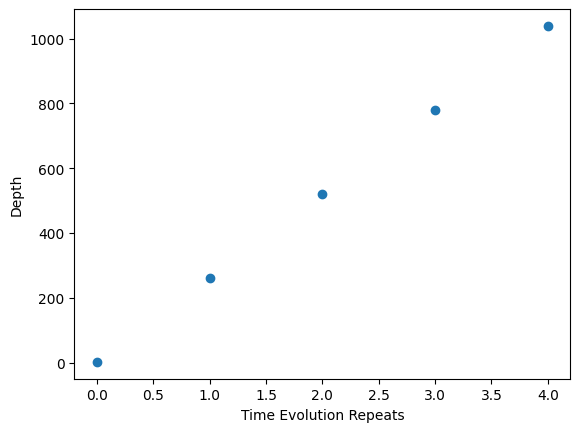

In [ ]:
plt.plot(range(0,5), depth_list, 'o')
plt.xlabel('Time Evolution Repeats')
plt.ylabel('Depth')
plt.show()

### For saving/loading data

Retrieving the outcomes of the data saved from the Hadamard test for the 3-spin, 1000 shots per timestep execution.

In [ ]:
#Mount your google drive as follows:
from google.colab import drive
drive.mount('/content/mydir')

# Query name of current folder
import os
folder_name=os.getcwd()
print(folder_name)

# Goto the Colab folder; should switch this to the actual google-drive folder
# where the notebook is located
os.chdir('/content/mydir/MyDrive/QuantumComputingQiskit/General_Tutorials')

folder_name=os.getcwd()
print(folder_name)

Mounted at /content/mydir
/content
/content/mydir/MyDrive/QuantumComputingQiskit/General_Tutorials


In [ ]:
if run_hadamard_test_boolean:
    print('Saving data...')
    np.savetxt('real_amp_array.csv', real_amp_array, fmt='%.18e', delimiter=';', newline='\n')
    np.savetxt('imag_amp_array.csv', imag_amp_array, fmt='%.18e', delimiter=';', newline='\n')
    np.savetxt('np_abs_correlation_with_hadamard_test.csv', np.abs(real_amp_array + 1j*imag_amp_array), fmt='%.18e', delimiter=';', newline='\n')
    np.savetxt('np_sqrt_sum_squares_correlation_with_hadamard_test.csv', np.sqrt(real_amp_array**2 + imag_amp_array**2), fmt='%.18e', delimiter=';', newline='\n')

### Loading pre-computed data

In [ ]:
real_amp_array = np.loadtxt('real_amp_array.csv', delimiter=';')
imag_amp_array = np.loadtxt('imag_amp_array.csv', delimiter=';')
np_abs_correlation_with_hadamard_test = np.loadtxt('np_abs_correlation_with_hadamard_test.csv', delimiter=';')
np_sqrt_sum_squares_correlation_with_hadamard_test = np.loadtxt('np_sqrt_sum_squares_correlation_with_hadamard_test.csv', delimiter=';')

### Plotting data

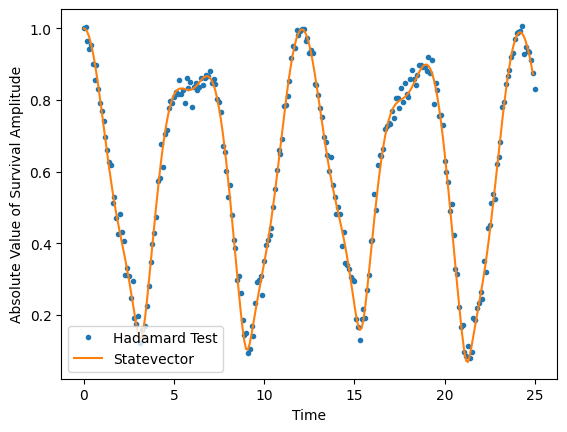

In [ ]:
n_x_points = len(correlation_list)
plt.plot(time_range, np.abs(real_amp_array + 1j*imag_amp_array), '.', label='Hadamard Test')
plt.plot(time_range[:n_x_points], np.abs(correlation_list), '-', label='Statevector')
plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude')
plt.legend()
plt.show()

# Heisenberg Model, using Tensor-Trains

Installing the libraries to make possible the use of the tensor-train representation. Note that when prompted to `Proceed (Y/n)?`, should type Y and then restart the runtime; this should allow ttpy to be installed without conflicts.

In [ ]:
# !pip install pylatexenc
# !pip uninstall numpy
# !pip install --upgrade numpy==1.23

In [ ]:
# !pip install git+https://github.com/oseledets/ttpy.git
!pip install git+https://github.com/bcallen95/ttpy.git

  Cloning https://github.com/bcallen95/ttpy.git to /tmp/pip-req-build-o09iy375
  Running command git clone --filter=blob:none --quiet https://github.com/bcallen95/ttpy.git /tmp/pip-req-build-o09iy375
  Resolved https://github.com/bcallen95/ttpy.git to commit 7cbb3a3ff190f00033d6534ea737f748365d6038
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ttpy: filename=ttpy-1.2.0-cp310-cp310-linux_x86_64.whl size=3888580 sha256=a2334380c7fc4bd879e849a483720bce08406ae22ffac4d0e71eeb026e93e86e
  Stored in directory: /tmp/pip-ephem-wheel-cache-uek3xmvs/wheels/75/0c/c3/e9f68d79cf0a3d4512aef01f589aec8f47513ba3633f972a16
Successfully built ttpy


## Necessary imports for the Tensor-Train section

In [ ]:
from __future__ import print_function, absolute_import, division
import sys
sys.path.append('../')

# import numpy as np
from numpy import linalg as LA
from scipy.integrate import solve_ivp

import math, tt
import tt.ksl
import time

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt
import networkx as nx
import scipy.special as sp
import numpy as np

## Functions implementing tensor-train evolution

### Heisenberg Hamiltonian with Tensor Trains
The Hamiltonian definition, equal to the one listed earlier in the notebook.

In [ ]:
# Heisenberg Hamiltonian in TT-format
def ham(N):
    # defining the Pauli matrices (in numpy array format)
    x = np.array([[0,1],[1,0]])
    y = np.array([[0,complex(0,-1)],[complex(0,1),0]])
    z = np.array([[1,0],[0,-1]])

    # converting the Pauli matrices to tt.matrix format
    tt_x=tt.matrix(x)
    tt_y=tt.matrix(y)
    tt_z=tt.matrix(z)

    # rounding threshold
    eps  = 1e-14

    # parameters of the model
    eps0 = 1.3/2 # on-site potential coefficent term (for 1st site)
    epsn = 2.0/2 # on-site potential coefficent term
    v0   = 0.75/2 # off-site kinetic coefficent term (for 1st site)
    vn   = 1.0/2 # off-site kinetic coefficent term
    # on-site potential hamiltonian matrix, initialized to zeros
    tt_H=0*tt.eye(2,N)
    tmp=tt_H
    k=0
    while k < N:
        if k == 0:
            tmp=tt.matrix(eps0*z)
            tmp=tt.kron(tmp,tt.eye(2,N-1))
        else:
            tmp=tt.kron(tt.eye(2,k),tt.matrix(epsn*z))
            tmp=tt.kron(tmp,tt.eye(2,N-k-1))
        tt_H=tt_H+tmp
        tt_H=tt_H.round(eps)
        k=k+1
    # off-site potential matrices, initialized to zero
    tt_HNNx=0*tt.eye(2,N) # XX
    tt_HNNy=tt_HNNx # YY
    tt_HNNz=tt_HNNx # ZZ
    k=0
    while k < N-1:
        if k == 0:
            tmpX=tt.kron(tt_x,tt_x)*v0
            tmpY=tt.kron(tt_y,tt_y)*v0
            tmpZ=tt.kron(tt_z,tt_z)*0
        else:
            tmp=tt.eye(2,k);
            tmpX=tt.kron(tmp,tt.kron(tt_x,tt_x)*vn)
            tmpY=tt.kron(tmp,tt.kron(tt_y,tt_y)*vn)
            tmpZ=tt.kron(tmp,tt.kron(tt_z,tt_z)*0)
        if k < N-2:
            tmpX=tt.kron(tmpX,tt.eye(2,N-2-k))
            tmpY=tt.kron(tmpY,tt.eye(2,N-2-k))
            tmpZ=tt.kron(tmpZ,tt.eye(2,N-2-k))
        tt_HNNx=tt_HNNx+tmpX
        tt_HNNy=tt_HNNy+tmpY
        tt_HNNz=tt_HNNz+tmpZ
        k=k+1
    # building the full Heisenberg Hamiltonian matrix and rounding
    tt_H=tt_H+tt_HNNx+tt_HNNy+tt_HNNz
    tt_H=tt_H.round(eps)
    return tt_H;

### Taylor's expansion of exp(A): scaling and squaring algorithm

In [ ]:
# Taylor's expansion of exp(A): scaling and squaring algorithm
# A TT-matrix
def expA(A,eps):
    global Nspins,rmax
    N=10 # number of terms in Taylor's expansion
    w0=A*(1.0/2**N)
    e=tt.eye(2,Nspins)
    e=tt.matrix(e)
    tm=e
    k=N-1
    while k > 0:
        tm=e+tm*w0*(1.0/k)
        tm=tm.round(eps,rmax)
        k=k-1
    while k < N:
        tm=tm*tm
        tm=tm.round(eps,rmax)
        k=k+1
    return tm

### Chebyshev expansion of exp(A)*v, Clenshaw algorithm

In [ ]:
# Chebyshev expansion of exp(A)*v, Clenshaw algorithm
# A TT-matrix, v TT-vector
from scipy.special import jv # Bessel function of the second kind
def exp_clen(A,v):
    eps=1e-14
    a=-1;b=1;n=12
    #  Dp = a+b
    Dm = b-a
    d0=0*v; d1=d0
    for j in range(n):
        d2=d1
        d1=d0
        k = n-1-j
        ck=(-1j)**(k)*jv(k,1j)
    #    d0=ck*v+tt.matvec(A,d1)*(4/Dm)-2*d1*(Dp/Dm)-d2
        d0=ck*v+tt.matvec(A,d1)*(4/Dm)-d2
        d0=d0.round(eps)
    return d0-d2

In [ ]:
# Clenshaw algorithm: Generates a tt of an arbitrary function func
# x is in TT format, either TT-vector or TT-matrix
# v could be provided as an argument to compute func*v (as in exp_clen)
def func_clen(x,func,v=None):
    b=1;a=-1; bma = 0.5 * (b - a); bpa = 0.5 * (b + a); n=12; eps=1e-14
    f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
    fac = 2.0 / n
    #c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
    #          for k in range(n)]) for j in range(n)]
    c = [2*(1j)**j * jv(j,-1j) for j in range(n)] # when func = np.exp
    nf=0
    if v == None:
        v=tt.eye(x.n[0],x.d)               # for exp(x), when x is a tt-matrix
        #  v=tt.ones(x.n[0],x.d)              # for exp(x), when x is a tt-vector
    else:
        nf=1

    y=x
    y2 = 2.0 * y
    (d, dd) = (c[-1]*v, 0*v)             # Special case first step for efficiency
    # Clenshaw's recurrence
    for cj in c[-2:0:-1]:
        if nf == 1:
            (d, dd) = (tt.matvec(y2,d) - dd + v * cj, d)    # to compute func*v
        else:
            (d, dd) = (y2 * d - dd + v * cj, d)
        d=d.round(eps)
        dd=dd.round(eps)
    if nf == 1:
        out = tt.matvec(y, d) - dd + 0.5 * c[0]*v        # to compute func*v
    else:
        out = y * d - dd + 0.5 * c[0]*v
    return out.round(eps)

## Time-evolution Parameters

If the number of spins here is switched to 20, this would reproduce the results in the reference listed ([Non-Markovian decay beyond the Fermi Golden Rule: Survival Collapse of the polarization in spin chains.](https://arxiv.org/pdf/quant-ph/0511176v2.pdf))

In [ ]:
# Simulation
N = 20
Nspins = N # number of spins in the system
rmax=4
su = np.array([1,0]) # spin-up vector
sd = np.array([0,1]) # spin down vector
tau=0.9 # time step
tfin=25 # final time; this does not appear to be used
nsteps=250 # number of time steps (resulting in total time tau * nsteps = 25)
eps=1e-14 # rounding threshold

y0=tt.tensor(su, eps) # inital state, spin up on first site
for j in range(N-1):
    y0=tt.kron(y0,tt.tensor(sd, eps)) # and spin-down on the subsequent sites

## Evolution of Tensor Train Forms

Performs the time-evolution with tensor trains using the ksl, Chebyshev and Taylor approximations.

In [ ]:
A = ham(N)*1j #complex(0.0,1.0), ie iH
Atau=A*tau # iHt
eA= expA(Atau,eps) # Taylor expansion of exp(Atau), exp(iHT)
eAc=func_clen(Atau,np.exp) # Chebyshev expansion of exp(Atau)

t= np.arange(0,tau*(nsteps),tau) # [0,250*0.1, 0.1]
p = np.empty_like(t)
pr = np.empty_like(t)
pc = np.empty_like(t)

radd = 2 #Modify this to increase the rank
if ( radd > 0 ):
    y0 = y0 + 1e-12*tt.rand(y0.n, y0.d, radd) #Hack, better by initialization

#y0 = y0.round(-1)

y0 = y0.round(1e-14) # initial state
y = y0.copy()
yr = y0.copy()
yc = y0.copy()

for k in range(nsteps):
    if k > 0:
        y = tt.ksl.ksl(A, y, tau);
        yr = tt.matvec(eA, yr)
        yr=yr.round(eps,radd)
#        yc = tt.matvec(eAc, yc) # commented out Chebyshev
        yc=exp_clen(Atau,yc)
##        yc=exp_clen(Atau*k,y0) # commented out Chebyshev
        yc=yc.round(eps,radd)
        ###        yc=func_clen(Atau,np.exp,yc)
    p[k] = abs(tt.dot(y,y0))
    pr[k] = abs(tt.dot(yr,y0))
    pc[k] = abs(tt.dot(yc,y0))

/usr/local/lib/python3.10/dist-packages/tt/core/vector.py:448: RuntimeWarning: invalid value encountered in multiply
  new_core = new_core * other


## Plotting All Results

In [ ]:
plt.yscale('log')
plt.plot(t,p,'b',label='ksl')
plt.plot(t,pr,'-',label='Taylor')
plt.plot(t,pc,'-',label='Chebyshev')
# plt.plot(t[:len(correlation_list)],  np.abs(correlation_list), 'o', label='Statevector')
# plt.plot(t, np.abs(real_amp_array + 1j*imag_amp_array)[:len(t)], '+', label='Hadamard Test')
plt.title('Heisenberg Model')
plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude')
# plt.xscale('log')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30),
          ncol=3, fancybox=True, shadow=True)
plt.show()